In [12]:
import pandas as pd
import numpy as np
import matplotlib
import os
from matplotlib import pyplot as plt

In [13]:
os.path.exists(os.path.join(os.curdir, 'tex_logs'))

True

In [14]:
matplotlib.rc('text', usetex = True)
params = {'backend': 'ps',
#           'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 14, # fontsize for x and y labels (was 10)
          'axes.titlesize': 14,
          'font.size': 10, # was 10
          'legend.fontsize': 10, # was 10
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Barplots for Single Models

In [15]:
from os.path import join

import shutil

def copy(dst):
    src = dst.replace('tex_logs', 'logs')
    shutil.copyfile(dst, src)

def plot_conv(df: pd.DataFrame, title='', acc=1.0):
    fig, ax = plt.subplots()
    col = list(df.columns)
    conv_layers = sorted([cl for cl in col if 'Conv-' in cl])
    conv_layers.sort(key=lambda x: (float(x.split('-')[-1]), len(x)))
    lin_layers = sorted([cl for cl in col if 'Lin-' in cl])
    lin_layers.sort(key=lambda x: (float(x.split('-')[-1]), len(x)))
    layer_cols = df[conv_layers+lin_layers].values[0]
    plt.plot(np.arange(0, len(layer_cols), 1), layer_cols/100)
    plt.scatter(np.arange(0, len(layer_cols), 1), layer_cols/100)
    plt.ylabel('Saturation')
    plt.xlabel('Layers')
    plt.xticks(np.arange(0, len(layer_cols), 1), conv_layers+lin_layers, rotation='vertical')
    plt.ylim(0,1)
    #plt.title(title)
    plt.grid(axis='y')
    plt.text(0.92, 0.85,f'test acc.:\t{round(acc, 3)}\n$s_\mu$:  {round(np.mean(layer_cols/100),3)}',
     horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes,
            fontsize=16)
    #print(layer_cols, lin_layers)
    
def plot_saturation_level_ax(cols, acc, ax):
    ax.grid()
    ax.plot(list(range(len(cols))), cols)
    ax.scatter(list(range(len(cols))), cols)

    ax.set_xticks([])
    ax.set_ylim((0,100))
    ax.text(3, 90, 'Accuray: {}'.format(acc))

def _extract_final_epoch_accuracy(run_csv_path) -> float:
    accs = []
    for t in [10000, 30000]:
        x = pd.read_csv(run_csv_path.replace('t10000', f't{t}'), sep=';')
        x = x['test_accuracy'].values[-1]
     #   print(x)
        if not np.isnan(x):
            accs.append(x)
    #print()
    return round(np.mean(accs), 3)

def _get_saturation_result_path(raw_path, sat_thresh) -> str:
    return raw_path.replace('.csv', f'_if{sat_thresh}.csv')

def _extract_data_from_saturation_pathfile(path):
    df = pd.read_csv(path, sep=';')
    col = list(df.columns)
    #print(col)
    conv_layers = sorted([cl for cl in col if 'Conv-' in cl])
    conv_layers.sort(key=lambda x: (float(x.split('-')[-1]), len(x)))
    lin_layers = sorted([cl for cl in col if 'Lin-' in cl])
    lin_layers.sort(key=lambda x: (float(x.split('-')[-1]), len(x)))
    layer_cols = df[conv_layers+lin_layers].values[0]
    names = conv_layers+lin_layers
    return names, layer_cols, np.mean(layer_cols)


def _extract_data_from_multiple_pathfiles(path):
    cols = []
    for t in [10000, 20000, 30000]:
        names, layer_cols, mean_cols = _extract_data_from_saturation_pathfile(path.replace('t10000', f't{t}'))
        cols.append(layer_cols)
    layer_cols = np.mean(cols, axis=0)
    return names, layer_cols, np.mean(layer_cols)
    
        
def extract_layer_saturation(run_csv_path):
    #print('Extracting', run_csv_path)
    acc = _extract_final_epoch_accuracy(run_csv_path)
    #print('Acc:', acc)
    filename = _get_saturation_result_path(run_csv_path, 0.99)
    #print('filename:', filename)
    names, layer_cols, avg_sat = _extract_data_from_multiple_pathfiles(filename)
    return names, layer_cols, acc, avg_sat

def plot_for_model(model, dataset, identifier, trial, filterstack, batch_size):
    filepath = join('.', 
                    'logs', 
                    'VGG{}{}'.format(model, filterstack), 
                    dataset, 
                    'VGG{}{}_bs{}_e30_t{}_id{}.csv'.format(model, filterstack, batch_size, trial, identifier))
    acc = _extract_final_epoch_accuracy(filepath)
    sat_file = _get_saturation_result_path(filepath, 0.99)
    df = pd.read_csv(sat_file, sep=';')
    mapper = {
        '' : 'full',
        '_S': 'halfed',
        '_XS': 'quartered',
        '_XXS': 'eigths',
        '_XXXS': 'sixteenth'
    }
    title = f'VGG{model} with {mapper[filterstack]} number of filters per layer'
    plot_conv(title=title, df=df, acc=acc)
    return filepath

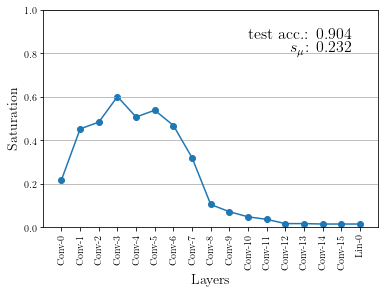

In [16]:
model = '19'
dataset = 'Cifar10'
filter_size = ''
trial = 30000
batch_size = 128
identifier = 'CenteredDim'

plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
plt.savefig(
    f"vgg19_sat.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)

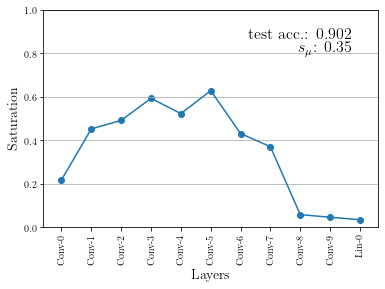

In [17]:
model = '13'
dataset = 'Cifar10'
filter_size = ''
trial = 30000
batch_size = 128
identifier = 'CenteredDim'

plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
plt.savefig(
    f"vgg13_sat.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)

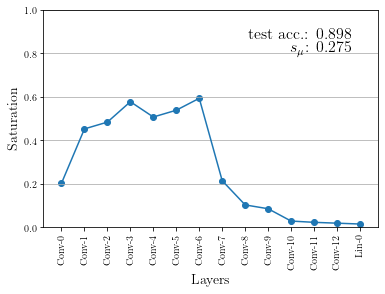

In [18]:
model = '16'
dataset = 'Cifar10'
filter_size = ''
trial = 30000
batch_size = 128
identifier = 'CenteredDim'

file = plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
#plt.savefig(
#    f"vgg16_sat.eps",
#    format="eps",
#    dpi=1000,
#    bbox_inches="tight",
#)

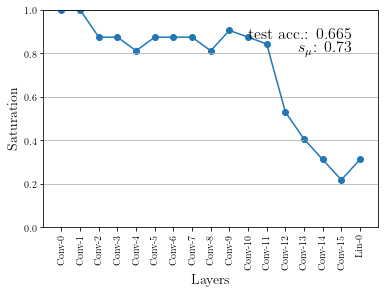

In [19]:
model = '19'
dataset = 'Cifar10'
filter_size = '_XXXS'
trial = 10000
batch_size = 128
identifier = 'CenteredDim'

plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
plt.savefig(
    f"vgg19xxxs_sat.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)

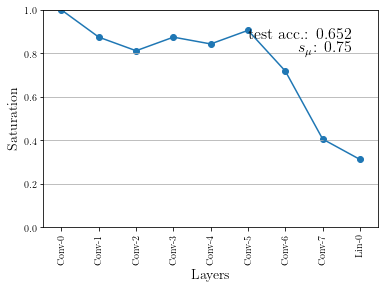

In [20]:
model = '11'
dataset = 'Cifar10'
filter_size = '_XXXS'
trial = 10000
batch_size = 128
identifier = 'CenteredDim'

file = plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
#plt.savefig(
#    f"vgg11xxxs_sat.eps",
#    format="eps",
#    dpi=1000,
#    bbox_inches="tight",
#)

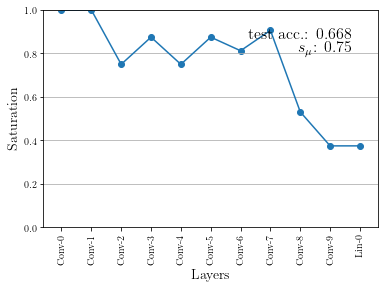

In [21]:
model = '13'
dataset = 'Cifar10'
filter_size = '_XXXS'
trial = 10000
batch_size = 128
identifier = 'CenteredDim'

plot_for_model(model, dataset, identifier, trial, filter_size, batch_size)
plt.savefig(
    f"vgg13xxxs_sat.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)

## Collages

FileNotFoundError: [Errno 2] File b'.\\tex_logs\\VGG11_XXXS\\Cifar100\\VGG11_XXXS_bs128_e30_t30000_idCenteredDim.csv' does not exist: b'.\\tex_logs\\VGG11_XXXS\\Cifar100\\VGG11_XXXS_bs128_e30_t30000_idCenteredDim.csv'

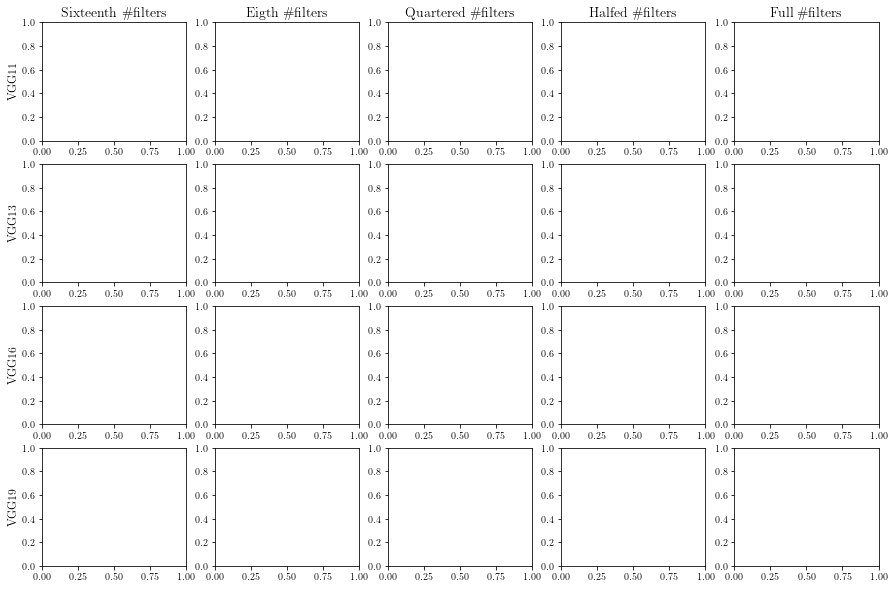

In [22]:
import matplotlib.pyplot as plt
from os.path import join
batch_size = 128
identifieer = 'CenteredDim'
trial = 10000
dataset = 'Cifar100'
cols = ['{} \#filters'.format(col) for col in reversed(['Full','Halfed', 'Quartered', 'Eigth', 'Sixteenth'])]
rows = ['{}'.format(row) for row in ['VGG11', 'VGG13', 'VGG16', 'VGG19']]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation='vertical', size='large')

    

#fig.tight_layout()
for i,net in enumerate([11, 13, 16, 19]):
    for j,filterstack in enumerate(reversed(['', '_S', '_XS', '_XXS', '_XXXS'])):
        filename = join('.','tex_logs','VGG{}{}'.format(net, filterstack), dataset,'VGG{}{}_bs{}_e30_t{}_id{}.csv'.format(net, filterstack, batch_size, trial, identifieer))
        #print(filename)
        copy(filename)
        col_names, cols, acc, avg_sat = extract_layer_saturation(filename)
        plot_saturation_level_ax(cols, acc, axes[i][j])
#plt.show()
#plt.savefig('collage_cifar.eps')
plt.savefig(
    f"cifar100_collage.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)

In [ ]:
import matplotlib.pyplot as plt
from os.path import join
batch_size = 128
identifieer = 'CenteredDim'
trial = 30000
dataset = 'Cifar10'
cols = ['{} \#filters'.format(col) for col in reversed(['Full','Halfed', 'Quartered', 'Eigth', 'Sixteenth'])]
rows = ['{}'.format(row) for row in ['VGG11', 'VGG13', 'VGG16', 'VGG19']]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation='vertical', size='large')

    

#fig.tight_layout()
for i,net in enumerate([11, 13, 16, 19]):
    for j,filterstack in enumerate(reversed(['', '_S', '_XS', '_XXS', '_XXXS'])):
        filename = join('.','tex_logs','VGG{}{}'.format(net, filterstack), dataset,'VGG{}{}_bs{}_e30_t{}_id{}.csv'.format(net, filterstack, batch_size, trial, identifieer))
        #print(filename)
        col_names, cols, acc, avg_sat = extract_layer_saturation(filename)
        plot_saturation_level_ax(cols, acc, axes[i][j])
#plt.show()
plt.savefig(
    f"cifar10_collage.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)
plt.savefig('collage_cifar.eps')

In [ ]:
import matplotlib.pyplot as plt
from os.path import join
batch_size = 128
identifieer = 'CenteredDim'
trial = 10000
dataset = 'CatVsDog'
cols = ['{} \#filters'.format(col) for col in reversed(['Full','Halfed', 'Quartered', 'Eigth', 'Sixteenth'])]
rows = ['{}'.format(row) for row in ['VGG11', 'VGG13', 'VGG16', 'VGG19']]

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation='vertical', size='large')

    

#fig.tight_layout()
for i,net in enumerate([11, 13, 16, 19]):
    for j,filterstack in enumerate(reversed(['', '_S', '_XS', '_XXS', '_XXXS'])):
        filename = join('.','tex_logs','VGG{}{}'.format(net, filterstack), dataset,'VGG{}{}_bs{}_e30_t{}_id{}.csv'.format(net, filterstack, batch_size, trial, identifieer))
        #print(filename)
        
        col_names, cols, acc, avg_sat = extract_layer_saturation(filename)
        plot_saturation_level_ax(cols, acc, axes[i][j])
#plt.show()
plt.savefig(
    f"cvd_collage.eps",
    format="eps",
    dpi=1000,
    bbox_inches="tight",
)
plt.savefig('collage_cifar.eps')